In [10]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

from IPython.display import clear_output
%matplotlib inline

### <p style="text-align: center; color: green;">Motion Estimation Pixel Wise (A) and Block Wise (B)</p> 

Nous allons ici faire une estimation pixel wise puis block wise d'un mouvement entre deux images.

Nous allons tout d'abord définir des constantes (hyper-paramètres) que l'on pourra changer par la suite pour vérifier nos résultats.

In [11]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

from IPython.display import clear_output
%matplotlib inline

OPTI_SLICING = 8
SEARCH_DIST_PIXEL = 4

BLOCK_LEN = 12
SEARCH_DIST_BLOCK = 8

LOOP_IMAGES = 1

### (A)
Pour la méthode pixel-wise nous parcourons les pixels voulu sur l'image 1 afin de ne pas prendre trop de temps et nous mappons les pixels aux alentours de l'image 2 dans une matrice pour pouvoir ensuite calculer la différence entre le pixel au centre (image 1) et ceux aux alentours (image 2). Ces résultats sont stockés dans une matrice et il suffit de prendre l'argument minimal de la matrice et de créer le vecteur.

### (B)
Pour la méthode block-wise, nous reprenons le principe des calculs matriciels de la méthode précédente. Cependant, nous devons mapper les alentours du pixel étudier sur l'image 1 ainsi que les alentours des pixels étudier sur l'image 2. Ensuite, nous étudions la différence block par block, c'est-à-dire pour le pixel supérieur gauche du premier block on étudiera sa différence avec le pixel supérieur gauche du second block, et ainsi de suite...

Nous allons créer une classe `Image` permettant d'utiliser facilement la méthode pixel-wise et block-wise depuis deux images:

In [12]:
def distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def estimate(deltaIntensity, dist):
    return 2 * deltaIntensity + dist / SEARCH_DIST_PIXEL

class Image:

    def __init__(self, pathImg):
        self.img = cv2.imread(pathImg)
        self.grayImage = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
        self.height, self.width = self.grayImage.shape[:2]

    # (A) Pixel-wise
    def differencePixelWise(self, other):
        vectors = np.full((self.height, self.width, 2), np.inf)
        # Get the indexes of the pixels to loop through
        y_idx = np.arange(0, self.height, OPTI_SLICING)
        x_idx = np.arange(0, self.width, OPTI_SLICING)

        # Get the indexes of the search area
        y2_idx, x2_idx = np.indices((2 * SEARCH_DIST_PIXEL + 1, 2 * SEARCH_DIST_PIXEL + 1))
        y2_idx -= SEARCH_DIST_PIXEL
        x2_idx -= SEARCH_DIST_PIXEL
        
        for i in range(len(y_idx)):
            for j in range(len(x_idx)):
                y2_idx_tmp = y2_idx + y_idx[i]
                x2_idx_tmp = x2_idx + x_idx[j]
                # Make sure the indexes are in the image
                y2_idx_tmp = np.clip(y2_idx_tmp, 0, self.height-1)
                x2_idx_tmp = np.clip(x2_idx_tmp, 0, self.width-1)
                # Get the intensity of the pixel and the intensity of the pixel in the search area
                intensity1 = self.grayImage[y_idx[i], x_idx[j]]
                intensity2 = other.grayImage[y2_idx_tmp, x2_idx_tmp]
                deltaIntensity = np.abs(intensity2 - intensity1)
                dist = distance(x_idx[j], y_idx[i], x2_idx_tmp, y2_idx_tmp)
                estimation = estimate(deltaIntensity, dist)
                # Get the indexes of the minimum value inside estimation
                idx = np.unravel_index(np.argmin(estimation, axis=None), estimation.shape)
                vectors[y_idx[i], x_idx[j], 0] = (x2_idx_tmp[idx] - x_idx[j]) * 2
                vectors[y_idx[i], x_idx[j], 1] = (y2_idx_tmp[idx] - y_idx[i]) * 2
        return vectors


    # (B) Block-wise
    def differenceBlockWise(self, other):
        vectors = np.zeros((self.height, self.width, 2))
        # Loop through all blocks
        for y in range(BLOCK_LEN//2, self.height, BLOCK_LEN):
            for x in range(BLOCK_LEN//2, self.width, BLOCK_LEN):
                # Get the block
                block = self.grayImage[y-BLOCK_LEN//2:y+BLOCK_LEN//2, x-BLOCK_LEN//2:x+BLOCK_LEN//2]
                # Make sure the block is the right size
                if block.shape != (BLOCK_LEN, BLOCK_LEN):
                    block = cv2.resize(block, (BLOCK_LEN, BLOCK_LEN))
                # Get the search area
                yMoves = np.arange(max(y-SEARCH_DIST_BLOCK, 0), min(y+SEARCH_DIST_BLOCK, self.height))
                xMoves = np.arange(max(x-SEARCH_DIST_BLOCK, 0), min(x+SEARCH_DIST_BLOCK, self.width))

                # Get the differences
                diff = np.zeros((len(yMoves), len(xMoves)))
                for i in range(len(yMoves)):
                    for j in range(len(xMoves)):
                        # Get the block in the search area
                        block2 = other.grayImage[max(yMoves[i]-BLOCK_LEN//2, 0):min(yMoves[i]+BLOCK_LEN//2, self.height), max(xMoves[j]-BLOCK_LEN//2, 0):min(xMoves[j]+BLOCK_LEN//2, self.width)]
                        # Make sure the blocks are the same size for border issues
                        if block2.shape != block.shape:
                            block2 = cv2.resize(block2, (BLOCK_LEN, BLOCK_LEN))
                        
                        # Get the difference using the estimation function
                        diff[i, j] = np.sum(2 * np.abs(block2 - block) + distance(x, y, xMoves[j], yMoves[i]))

                # Get the index of the minimum difference
                idx = np.unravel_index(np.argmin(diff, axis=None), diff.shape)
                # Get the vector
                vectors[y, x, 0] = (xMoves[idx[1]] - x) * 2
                vectors[y, x, 1] = (yMoves[idx[0]] - y) * 2
        return vectors

Une boucle est utilisée pour pouvoir itérer sur l'ensemble d'images. Nous appelons les méthodes pour remplir une matrice de vecteurs et `ax.quiver` nous permet de tracer les vecteurs.
Voici le pixel-wise:

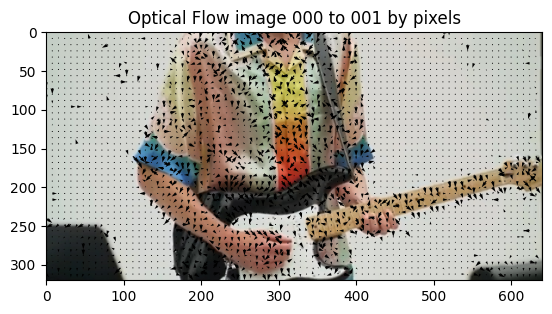

In [13]:
for i in range(LOOP_IMAGES):
    # create a new figure
    fig, ax = plt.subplots()

    # Charger les deux images
    img1 = Image('images/LF' + str(i).zfill(3) + '.jpg')
    img2 = Image('images/LF' + str(i + 1).zfill(3) + '.jpg')
    
    ax.clear()
    ax.imshow(cv2.cvtColor(img1.img, cv2.COLOR_BGR2RGB))

    # Calcul des vecteurs de mouvement
    vectors = img1.differencePixelWise(img2)

    # draw the vectors using quiver
    ax.quiver(np.arange(0, img1.width, OPTI_SLICING), np.arange(0, img1.height, OPTI_SLICING),
              vectors[::OPTI_SLICING, ::OPTI_SLICING, 0], vectors[::OPTI_SLICING, ::OPTI_SLICING, 1], angles='xy', scale_units='xy', scale=1)
                 

    # set the x and y limits of the plot
    ax.set_xlim([0, img1.width])
    ax.set_ylim([0, img1.height])
    ax.set_title('Optical Flow image ' + str(i).zfill(3) +
                 ' to ' + str(i + 1).zfill(3) + ' by pixels')

    # Reverse the image
    ax.invert_yaxis()

    # show the plot
    plt.pause(1)
    clear_output(wait=True)

Quasiment tout les vecteurs de mouvement se trouvent sur la personne et la guitare ce qui est un bon indicateur d'où provient le mouvement. Cependant, ses vecteurs sont assez désordonnés voyons voir si cela s'améliore sur le block wise.

Et voici le block-wise:

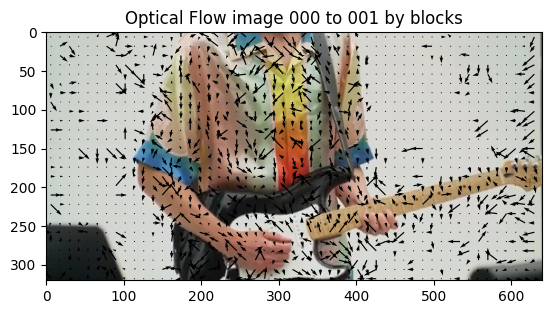

In [17]:
for i in range(LOOP_IMAGES):
    # create a new figure
    fig, ax = plt.subplots()

    # Charger les deux images
    img1 = Image('images/LF' + str(i).zfill(3) + '.jpg')
    img2 = Image('images/LF' + str(i + 1).zfill(3) + '.jpg')
    
    ax.clear()
    ax.imshow(cv2.cvtColor(img1.img, cv2.COLOR_BGR2RGB))

    # Calcul des vecteurs de mouvement
    vectors = img1.differenceBlockWise(img2)

    # draw the vectors using quiver
    ax.quiver(np.arange(BLOCK_LEN // 2, img1.width, BLOCK_LEN), np.arange(BLOCK_LEN // 2, img1.height, BLOCK_LEN),
                vectors[BLOCK_LEN // 2::BLOCK_LEN, BLOCK_LEN // 2::BLOCK_LEN, 0], vectors[BLOCK_LEN // 2::BLOCK_LEN, BLOCK_LEN // 2::BLOCK_LEN, 1], angles='xy', scale_units='xy', scale=1)
    
    # set the x and y limits of the plot
    ax.set_xlim([0, img1.width])
    ax.set_ylim([0, img1.height])
    ax.set_title('Optical Flow image ' + str(i).zfill(3) +
                    ' to ' + str(i + 1).zfill(3) + ' by blocks')
    
    # Reverse the image
    ax.invert_yaxis()

    # show the plot
    plt.pause(1)
    clear_output(wait=True)
    

Nous pouvons remarquer que les vecteurs sont toujours majoritairement sur la personne et la guitare mais beaucoup se sont créés en périphérie et sur le bord droit.  
Un coefficient plus élevé sur la distance lors du calcul de différence serait peut être plus judicieux pour essayer de réduire le nombres de vecteurs en dehors du mouvement réel.  

Les vecteurs ne sont là aussi pas uniformiser, c'est-à-dire qu'ils vont chacun dans un sens assez différents. Une régularisation des vecteurs serait une bonne chose afin de déterminer des mouvements général locaux sur l'image.  

Nous verrons une régularisation dans la partie node based.